In [1]:
import requests
import pandas as pd
import numpy as np
import re
import spacy
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import gensim
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from nltk import sentiment
from pprint import pprint
from IPython.display import display, clear_output
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

c:\Users\Rahul\miniconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
def DATA_EXTRACTOR(link):
    response = requests.get(link)
    soup = BeautifulSoup(response.content, "html.parser")
    content = soup.find_all('article', class_ = lambda value: value and value.startswith("review-"))
    review_details = []
    passenger_details = []

    for i in content:
        review_detail = {}
        review_detail["Date"] = i.find("meta").get("content") if i.find("meta") else None
        review_detail["Title"] = i.find("h2").get_text() if i.find("h2") else None
        review_detail["Rating"] = i.find("span", {"itemprop": "ratingValue"}).get_text() if i.find("span", {"itemprop": "ratingValue"}) else None
        review_detail["Review"] = i.find("div", {"class": "text_content"}).get_text() if i.find("div", {"class": "text_content"}) else None
        review_details.append(review_detail)

        passenger_detail = {}
        table = i.find("table", { "class": "review-ratings" })
        if table:
            data = table.find_all("td")
            keys = data[::2]
            values = data[1::2]
            for key, value in zip(keys, values):
                key = key.get_text()
                star_value = None
                try:
                    star_value = value.find_all("span", { "class": "star fill" })[-1]
                except:
                    pass
                if star_value:
                    value = star_value.get_text()
                else:
                    value = value.get_text()
                passenger_detail[key] = value
        passenger_details.append(passenger_detail)

    raw_data = pd.concat([pd.DataFrame(review_details), pd.DataFrame(passenger_details)], axis=1)
    return raw_data

In [3]:
data = pd.DataFrame()
for page in range(1,40):
    page_url = f"https://www.airlinequality.com/airline-reviews/british-airways/page/{page}/?sortby=post_date%3ADesc&pagesize=100"
    print(f"Processing page {page}")
    try:
        _ = DATA_EXTRACTOR(page_url)
        data = pd.concat([data, _], ignore_index=True)
    except Exception as e:
        print(f"Failed to process page {page}: {e}")

data['Verification'] = data['Review'].apply(lambda x: x.split('|')[0].strip() if '|' in x else 'Not Verified')
data['Review'] = data['Review'].apply(lambda x: x.split('|')[1].strip() if '|' in x else x.strip())
data.to_csv('data.csv', index=False)

'data = pd.DataFrame()\nfor page in range(1,40):\n    page_url = f"https://www.airlinequality.com/airline-reviews/british-airways/page/{page}/?sortby=post_date%3ADesc&pagesize=100"\n    print(f"Processing page {page}")\n    try:\n        _ = DATA_EXTRACTOR(page_url)\n        data = pd.concat([data, _], ignore_index=True)\n    except Exception as e:\n        print(f"Failed to process page {page}: {e}")\n\ndata[\'Verification\'] = data[\'Review\'].apply(lambda x: x.split(\'|\')[0].strip() if \'|\' in x else \'Not Verified\')\ndata[\'Review\'] = data[\'Review\'].apply(lambda x: x.split(\'|\')[1].strip() if \'|\' in x else x.strip())\ndata.to_csv(\'data.csv\', index=False)'

In [4]:
data = pd.read_csv('data.csv')
data.head()

,Date,Title,Rating,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Value For Money,Recommended,Wifi & Connectivity,Verification
0,2024-08-11,“customer service has been horrible”,3.0,I recently traveled with British Airways and h...,A380,Family Leisure,Economy Class,Barcelona to Dallas via Heathrow,August 2024,3.0,4.0,4.0,4.0,2.0,3.0,no,NaN,✅ Trip Verified
1,2024-08-09,"""Not as much as an apology""",1.0,My family and I were booked to leave London fo...,NaN,Family Leisure,Economy Class,London to Hong Kong,August 2024,1.0,NaN,NaN,NaN,1.0,1.0,no,NaN,✅ Trip Verified
2,2024-08-08,"""no one attending or caring""",2.0,We had to change from AA to BA for a flight to...,NaN,Couple Leisure,Economy Class,Dallas to London,May 2024,2.0,2.0,2.0,2.0,2.0,2.0,no,2.0,Not Verified
3,2024-08-08,“disappointed in British Airways”,2.0,After paying $6500 for tickets for my family (...,Boeing 777,Family Leisure,Economy Class,London to Tampa,August 2024,1.0,1.0,1.0,4.0,3.0,1.0,no,3.0,✅ Trip Verified
4,2024-08-07,"""easy and enjoyable flight""",8.0,An excellent flight on BA CityFlyer. The plane...,Embraer 190,Couple Leisure,Economy Class,Dublin to London City,July 2024,4.0,4.0,3.0,NaN,4.0,4.0,yes,NaN,✅ Trip Verified


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3838 entries, 0 to 3837
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    3838 non-null   object 
 1   Title                   3838 non-null   object 
 2   Rating                  3833 non-null   float64
 3   Review                  3838 non-null   object 
 4   Aircraft                2001 non-null   object 
 5   Type Of Traveller       3067 non-null   object 
 6   Seat Type               3836 non-null   object 
 7   Route                   3063 non-null   object 
 8   Date Flown              3060 non-null   object 
 9   Seat Comfort            3715 non-null   float64
 10  Cabin Staff Service     3701 non-null   float64
 11  Food & Beverages        3420 non-null   float64
 12  Inflight Entertainment  2623 non-null   float64
 13  Ground Service          2989 non-null   float64
 14  Value For Money         3837 non-null   

In [6]:
data.isnull().sum()

Date                         0
Title                        0
Rating                       5
Review                       0
Aircraft                  1837
Type Of Traveller          771
Seat Type                    2
Route                      775
Date Flown                 778
Seat Comfort               123
Cabin Staff Service        137
Food & Beverages           418
Inflight Entertainment    1215
Ground Service             849
Value For Money              1
Recommended                  0
Wifi & Connectivity       3178
Verification                 0
dtype: int64

In [7]:
print(data['Type Of Traveller'].unique())
print(data['Seat Type'].unique())
print(data['Verification'].unique())

['Family Leisure' 'Couple Leisure' 'Solo Leisure' 'Business' nan]
['Economy Class' 'Business Class' 'Premium Economy' 'First Class' nan]
['✅ Trip Verified' 'Not Verified' 'cNot Verified' '❎ Not Verified'
 '✅ Verified Review' '❎ Unverified'
 'We travelled economy from Manchester to Toronto via Heathrow The flight from Manchester to Heathrow and return was very good. The seats had plenty of room and it was easy to fit laptop size briefcases under the seat in front and still have room to stretch your legs. The service from the cabin crew was excellent. The leg from Heathrow to Toronto was not as comfortable but it was acceptable. The seats appeared narrower and my case only just fit under the seat leaving little room to stretch my legs. Whilst the cabin crew forgot requests for drinks they apologised and were very friendly and helpful in other aspects. Unfortunately BA were let down by the attendants on the return leg from Toronto to Heathrow. Whilst the aircraft appeared newer and more c

In [8]:
data = (
    data
    .fillna({'Rating': '-1', 'Seat Type': '-1'})
    .query('Rating != "-1" and `Seat Type` != "-1"')
)

num_cols = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity', 'Value For Money']
cat_cols = ['Type Of Traveller', 'Seat Type', 'SENTIMENT', 'TOPIC']
data[num_cols] = data[num_cols].fillna(0)

data['Type Of Traveller'] = data['Type Of Traveller'].fillna('No Data')
data['Route'] = data['Route'].fillna('No Data')
data['Date Flown'] = data['Date Flown'].fillna('No Data')
data['Aircraft'] = data['Aircraft'].fillna('No Data')

data['Date'] = pd.to_datetime(data['Date']).dt.strftime('%B %Y')

In [9]:
data = data[data['Review'] != ") I did not see the attendants down our aisle smile at a customer once throughout the whole journey."]

ver_map = {
    '✅ Verified Review': 'Yes',
    '✅ Trip Verified': 'Yes',
    'Not Verified': 'No',
    '❎ Not Verified': 'No',
    'cNot Verified': 'No',
    '❎ Unverified': 'No',
}
data['Verification'] = data['Verification'].replace(ver_map)

In [10]:
data[['From', 'To']] = data['Route'].apply(lambda x: pd.Series(x.split(' to ', 1) if isinstance(x, str) and ' to ' in x else ['No Data', 'No Data']))
data.drop('Route', axis=1, inplace=True)

In [11]:
contractions = { 
    "ain't": "am not / are not / is not / has not / have not",
    "aren't": "are not / am not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had / he would",
    "he'd've": "he would have",
    "he'll": "he shall / he will",
    "he'll've": "he shall have / he will have",
    "he's": "he has / he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how has / how is / how does",
    "I'd": "I had / I would",
    "I'd've": "I would have",
    "I'll": "I shall / I will",
    "I'll've": "I shall have / I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had / it would",
    "it'd've": "it would have",
    "it'll": "it shall / it will",
    "it'll've": "it shall have / it will have",
    "it's": "it has / it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had / she would",
    "she'd've": "she would have",
    "she'll": "she shall / she will",
    "she'll've": "she shall have / she will have",
    "she's": "she has / she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as / so is",
    "that'd": "that would / that had",
    "that'd've": "that would have",
    "that's": "that has / that is",
    "there'd": "there had / there would",
    "there'd've": "there would have",
    "there's": "there has / there is",
    "they'd": "they had / they would",
    "they'd've": "they would have",
    "they'll": "they shall / they will",
    "they'll've": "they shall have / they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what shall / what will",
    "what'll've": "what shall have / what will have",
    "what're": "what are",
    "what's": "what has / what is",
    "what've": "what have",
    "when's": "when has / when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where has / where is",
    "where've": "where have",
    "who'll": "who shall / who will",
    "who'll've": "who shall have / who will have",
    "who's": "who has / who is",
    "who've": "who have",
    "why's": "why has / why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had / you would",
    "you'd've": "you would have",
    "you'll": "you shall / you will",
    "you'll've": "you shall have / you will have",
    "you're": "you are",
    "you've": "you have"
}

In [12]:
NLP_MODEL = spacy.load('en_core_web_sm')
STOPS = set(stopwords.words('english'))

def tls(s):
    doc = NLP_MODEL(s)
    speech = [token.lemma_ for token in doc]
    return speech

def stop_words(s):
    words = s.split()
    clean = [word for word in words if word not in STOPS]
    s = ' '.join(clean)
    return s

def number_to_words(num):
    to_19 = 'one two three four five six seven eight nine ten eleven twelve thirteen fourteen fifteen sixteen seventeen eighteen nineteen'.split()
    tens = 'twenty thirty forty fifty sixty seventy eighty ninety'.split()
    
    def words(n):
        if num == 0:
            return 'zero'
        if n < 20:
            return to_19[n-1:n][0]
        if n < 100:
            return tens[n//10-2] + ('' if n%10==0 else ' ' + words(n%10))
        if n < 1000:
            return to_19[n//100-1] + ' hundred' + ('' if n%100==0 else ' and ' + words(n%100))
        for p, w in enumerate(('thousand', 'million', 'billion'), 1):
            if n < 1000**(p+1):
                return words(n//1000**p) + ' ' + w + ('' if n%1000**p==0 else ' ' + words(n%1000**p))
    
    return words(num)

def replace_numbers(text):
    for word in re.findall(r'\b\d+\b', text):
        num = int(word)
        new_word = number_to_words(num)
        text = text.replace(word, new_word)
    return text

In [13]:
def PRE_PROCESSOR(r):
    r = r.lower()

    r = r.replace('%', ' percent ')
    r = r.replace('$', ' dollar ')
    r = r.replace('₹', ' rupee ')
    r = r.replace('€', ' euro ')
    r = r.replace('@', ' at ')

    r_contract = []
    for word in r.split():
        if word in contractions:
            word = contractions[word]
        r_contract.append(word)
    
    r = ' '.join(r_contract)
    r = r.replace("'ve", ' have')
    r = r.replace("'t", ' not')
    r = r.replace("'re", ' are')
    r = r.replace("'ll", ' will')
    r = r.replace("'m", " am")
    r = r.replace("'s", " ")

    punct = re.compile(r'[^\w\s]')
    r = re.sub(punct, '', r).strip()

    r = replace_numbers(r)
    
    words__ = tls(r)
    r = ' '.join(words__)

    r = stop_words(r)

    return r

In [14]:
data['TITLE'] = data['Title'].apply(PRE_PROCESSOR)
data['REVIEW'] = data['Review'].apply(PRE_PROCESSOR)
data.to_csv('preprocess.csv')

"data['TITLE'] = data['Title'].apply(PRE_PROCESSOR)\ndata['REVIEW'] = data['Review'].apply(PRE_PROCESSOR)\ndata.to_csv('preprocess.csv')"

In [15]:
data = pd.read_csv('preprocess.csv')
data.head()

,Unnamed: 0,Date,Title,Rating,Review,Aircraft,Type Of Traveller,Seat Type,Date Flown,Seat Comfort,...,Inflight Entertainment,Ground Service,Value For Money,Recommended,Wifi & Connectivity,Verification,From,To,TITLE,REVIEW
0,0,August 2024,“customer service has been horrible”,3.0,I recently traveled with British Airways and h...,A380,Family Leisure,Economy Class,August 2024,3.0,...,4.0,2.0,3.0,no,0.0,Yes,Barcelona,Dallas via Heathrow,customer service horrible,I recently travel british airways mixed experi...
1,1,August 2024,"""Not as much as an apology""",1.0,My family and I were booked to leave London fo...,No Data,Family Leisure,Economy Class,August 2024,1.0,...,0.0,1.0,1.0,no,0.0,Yes,London,Hong Kong,much apology,family I book leave london hong kong two augus...
2,2,August 2024,"""no one attending or caring""",2.0,We had to change from AA to BA for a flight to...,No Data,Couple Leisure,Economy Class,May 2024,2.0,...,2.0,2.0,2.0,no,2.0,No,Dallas,London,one attend care,change aa ba flight london miss connection fli...
3,3,August 2024,“disappointed in British Airways”,2.0,After paying $6500 for tickets for my family (...,Boeing 777,Family Leisure,Economy Class,August 2024,1.0,...,4.0,3.0,1.0,no,3.0,Yes,London,Tampa,disappoint british airways,pay dollar six thousand five hundred ticket fa...
4,4,August 2024,"""easy and enjoyable flight""",8.0,An excellent flight on BA CityFlyer. The plane...,Embraer 190,Couple Leisure,Economy Class,July 2024,4.0,...,0.0,4.0,4.0,yes,0.0,Yes,Dublin,London City,easy enjoyable flight,excellent flight ba cityflyer plane clean comf...


In [16]:
titles = ' '.join([word for word in data['TITLE']])
reviews = ' '.join([word for word in data['REVIEW']])

(-0.5, 599.5, 399.5, -0.5)

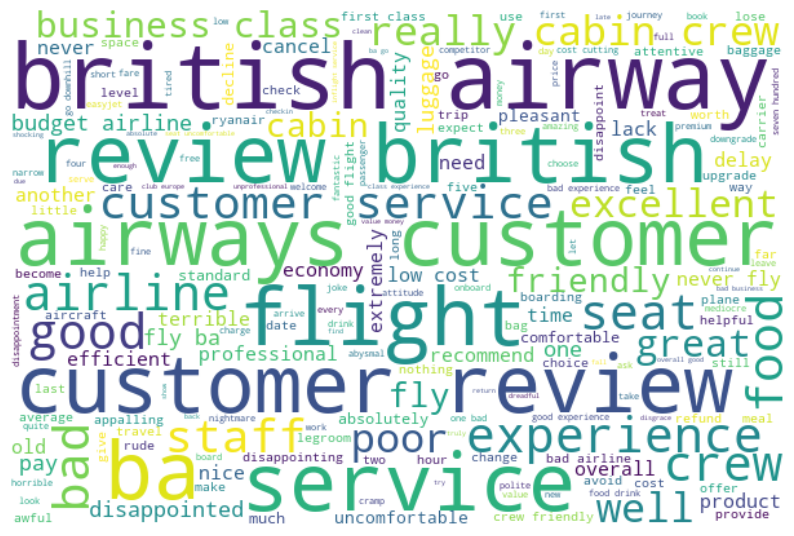

In [17]:
wordcloud = WordCloud(width=600,
                     height=400,
                     random_state=2,
                     background_color="white",
                     repeat=True,
                     max_font_size=100).generate(titles)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

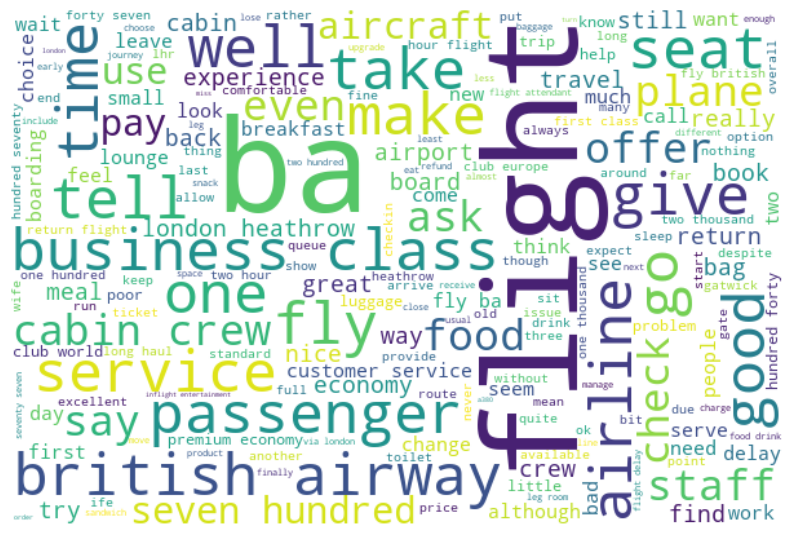

In [18]:
wordcloud = WordCloud(width=600,
                     height=400,
                     random_state=2,
                     background_color="white",
                     repeat=True,
                     max_font_size=100).generate(reviews)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [19]:
dist_title = nltk.probability.FreqDist(titles.split())
dist_title.most_common(25)

[('customer', 1038),
 ('british', 1035),
 ('airways', 1008),
 ('review', 950),
 ('service', 315),
 ('ba', 241),
 ('flight', 225),
 ('I', 187),
 ('experience', 166),
 ('crew', 164),
 ('airline', 155),
 ('seat', 147),
 ('good', 139),
 ('bad', 122),
 ('cabin', 96),
 ('fly', 94),
 ('food', 88),
 ('friendly', 79),
 ('staff', 75),
 ('class', 67),
 ('never', 64),
 ('cost', 54),
 ('business', 52),
 ('well', 52),
 ('poor', 50)]

In [20]:
dist_review = nltk.probability.FreqDist(reviews.split())
dist_review.most_common(25)

[('I', 14004),
 ('flight', 8155),
 ('ba', 4959),
 ('seat', 4813),
 ('service', 3083),
 ('one', 2632),
 ('fly', 2523),
 ('time', 2511),
 ('good', 2487),
 ('food', 2400),
 ('get', 2340),
 ('crew', 2303),
 ('british', 2231),
 ('london', 2224),
 ('cabin', 2110),
 ('two', 2029),
 ('class', 2002),
 ('hour', 1930),
 ('hundred', 1914),
 ('airline', 1768),
 ('airways', 1731),
 ('would', 1727),
 ('business', 1654),
 ('seven', 1653),
 ('staff', 1638)]

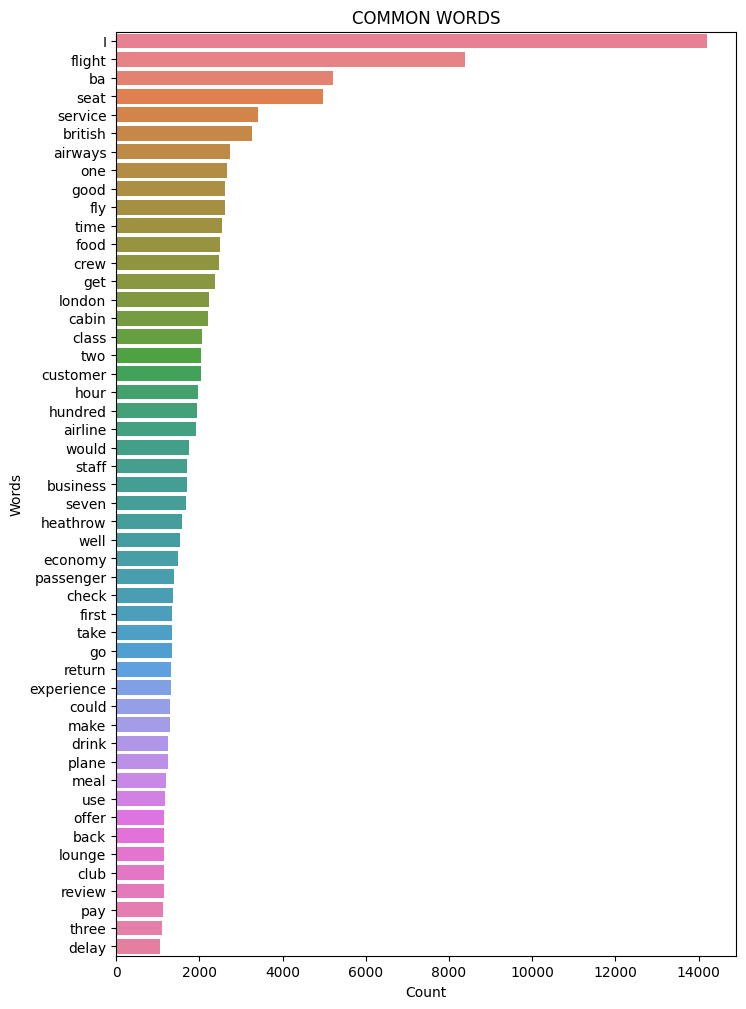

In [21]:
dist_total = nltk.probability.FreqDist((titles + reviews).split())
most_common = pd.Series(dict(dist_total.most_common(50)))

plt.figure(figsize=(8, 12))
sns.barplot(x=most_common.values, y=most_common.index, hue=most_common.index, legend=False)
plt.title('COMMON WORDS')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

In [22]:
analyzer = nltk.sentiment.SentimentIntensityAnalyzer()

data['POLARITY'] = data['REVIEW'].apply(lambda x: analyzer.polarity_scores(x))
data = pd.concat([data.drop(['POLARITY'], axis=1), data['POLARITY'].apply(pd.Series)], axis=1)
#data['SENTIMENT'] = data['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
data['SENTIMENT'] = np.where(data['compound'] < 0, 'negative', np.where(data['compound'] > 0.7, 'positive', 'neutral'))
data.to_csv('sentiment.csv')

In [23]:
data = pd.read_csv('sentiment.csv')
data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
data.head()

,Date,Title,Rating,Review,Aircraft,Type Of Traveller,Seat Type,Date Flown,Seat Comfort,Cabin Staff Service,...,Verification,From,To,TITLE,REVIEW,neg,neu,pos,compound,SENTIMENT
0,August 2024,“customer service has been horrible”,3.0,I recently traveled with British Airways and h...,A380,Family Leisure,Economy Class,August 2024,3.0,4.0,...,Yes,Barcelona,Dallas via Heathrow,customer service horrible,I recently travel british airways mixed experi...,0.156,0.762,0.082,-0.8360,negative
1,August 2024,"""Not as much as an apology""",1.0,My family and I were booked to leave London fo...,No Data,Family Leisure,Economy Class,August 2024,1.0,0.0,...,Yes,London,Hong Kong,much apology,family I book leave london hong kong two augus...,0.189,0.767,0.043,-0.8689,negative
2,August 2024,"""no one attending or caring""",2.0,We had to change from AA to BA for a flight to...,No Data,Couple Leisure,Economy Class,May 2024,2.0,2.0,...,No,Dallas,London,one attend care,change aa ba flight london miss connection fli...,0.155,0.649,0.196,0.3709,neutral
3,August 2024,“disappointed in British Airways”,2.0,After paying $6500 for tickets for my family (...,Boeing 777,Family Leisure,Economy Class,August 2024,1.0,1.0,...,Yes,London,Tampa,disappoint british airways,pay dollar six thousand five hundred ticket fa...,0.144,0.661,0.195,0.7506,positive
4,August 2024,"""easy and enjoyable flight""",8.0,An excellent flight on BA CityFlyer. The plane...,Embraer 190,Couple Leisure,Economy Class,July 2024,4.0,4.0,...,Yes,Dublin,London City,easy enjoyable flight,excellent flight ba cityflyer plane clean comf...,0.000,0.401,0.599,0.9870,positive


In [24]:
sent_count = data.SENTIMENT.value_counts()
sent_count

SENTIMENT
positive    1898
negative    1262
neutral      670
Name: count, dtype: int64

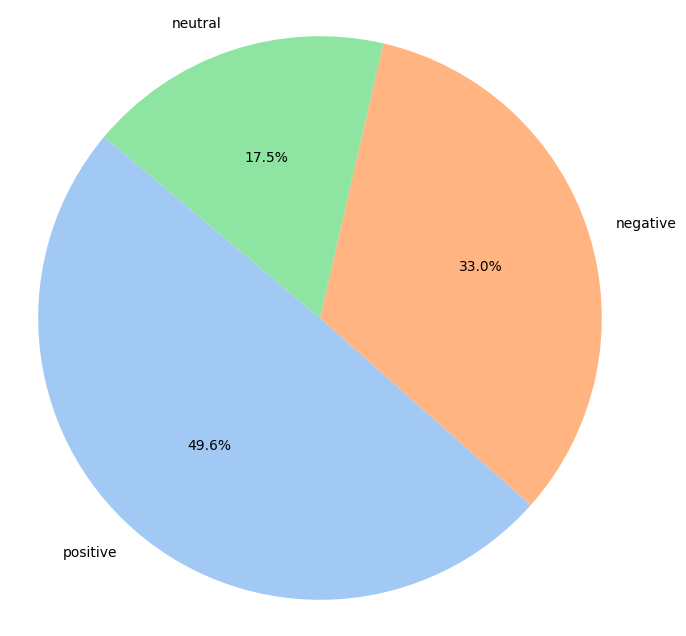

In [25]:
sentiments = sent_count.index
sizes = sent_count.values
colors = sns.color_palette('pastel')[0:3]

plt.figure(figsize=(8,8))
plt.pie(sizes, labels=sentiments, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()

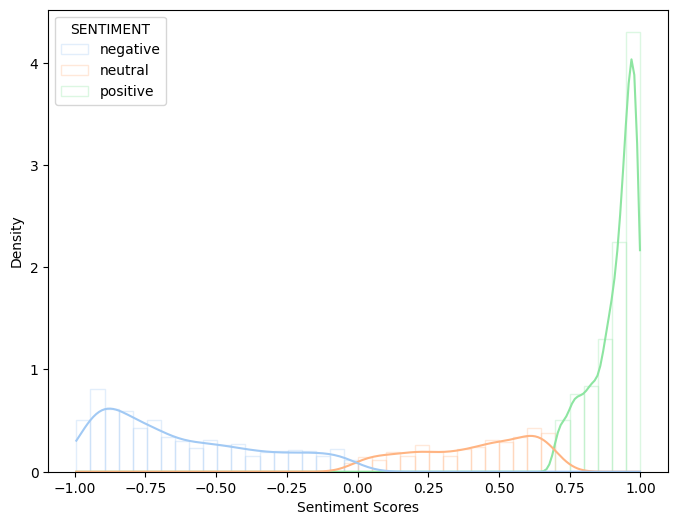

In [26]:
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='compound', hue='SENTIMENT', bins=40, kde=True, fill=False, stat='density', alpha=0.3, palette='pastel')
plt.xlabel("Sentiment Scores")
plt.ylabel("Density")
plt.show()

In [29]:
def sent_to_words(sen):
    for s in sen:
        s = re.sub(r'\s+', ' ', s)
        s = re.sub(r"\'", "", s)
        s = gensim.utils.simple_preprocess(str(s), deacc=True) 
        yield(s)

content = data.Review.values.tolist()
words = list(sent_to_words(content))

In [30]:
bigram = gensim.models.Phrases(words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[words], threshold=100)
BIGRAM_MODEL = gensim.models.phrases.Phraser(bigram)
TRIGRAM_MODEL = gensim.models.phrases.Phraser(trigram)

def PROCESSOR(t, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    t = [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in STOPS] for doc in t]
    t = [BIGRAM_MODEL[doc] for doc in t]
    t = [TRIGRAM_MODEL[BIGRAM_MODEL[doc]] for doc in t]

    t_out = []
    for s in t:
        doc = NLP_MODEL(' '.join(s))
        t_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    t_out = [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in STOPS] for doc in t_out]
    return t_out

total_words = PROCESSOR(words)

In [31]:
id2word = gensim.corpora.Dictionary(total_words)
# bag of words
corpus = [id2word.doc2bow(text) for text in total_words]

LDA_MODEL = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, random_state=100, update_every=1, chunksize=10, passes=10, alpha='symmetric', iterations=100, per_word_topics=True)
pprint(LDA_MODEL.print_topics())

[(0,
  '0.042*"flight" + 0.026*"good" + 0.026*"crew" + 0.022*"cabin" + 0.020*"food" '
  '+ 0.016*"time" + 0.014*"service" + 0.011*"drink" + 0.010*"seat" + '
  '0.010*"meal"'),
 (1,
  '0.048*"flight" + 0.019*"hour" + 0.017*"check" + 0.015*"get" + 0.013*"delay" '
  '+ 0.013*"tell" + 0.013*"go" + 0.011*"time" + 0.010*"book" + 0.009*"take"'),
 (2,
  '0.050*"seat" + 0.023*"fly" + 0.019*"class" + 0.016*"business" + '
  '0.013*"economy" + 0.012*"get" + 0.011*"airline" + 0.010*"ba" + 0.009*"food" '
  '+ 0.009*"service"')]


In [32]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(LDA_MODEL, corpus, dictionary=LDA_MODEL.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.232628  0.004397       1        1  36.133858
2      0.112327 -0.194600       2        1  32.761367
1      0.120301  0.190203       3        1  31.104776, topic_info=          Term         Freq        Total Category  logprob  loglift
350       seat  5180.000000  5180.000000  Default  30.0000  30.0000
151       good  2440.000000  2440.000000  Default  29.0000  29.0000
176       crew  2433.000000  2433.000000  Default  28.0000  28.0000
432      cabin  2061.000000  2061.000000  Default  27.0000  27.0000
21      flight  8220.000000  8220.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
300  passenger   548.646958  1314.098213   Topic3  -4.9861   0.2944
129      plane   520.520847  1352.970808   Topic3  -5.0387   0.2126
30        make   473.850447  1029.308378   Topic3  -5.1327   0.3921
229   heathrow   440.180303   754.548773   Topic3  -5.2064   0.6289
41     service   448.712845  2466.427098   Topic3  -5.1872  -0.5363

[205 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
375       2  0.006763   advance
375       3  0.994212   advance
883       3  0.997590     agent
51        1  0.762061  aircraft
51        2  0.237141  aircraft
...     ...       ...       ...
1645      3  0.003058      wine
1810      2  0.995931     world
1810      3  0.008892     world
143       2  0.998266      year
143       3  0.002371      year

[354 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [33]:
def assign_topic(review_corpus):
    topic_distribution = LDA_MODEL.get_document_topics(review_corpus)
    assigned_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return assigned_topic

data['TOPIC'] = [assign_topic(bow) for bow in corpus]

In [35]:
data.head()

,Date,Title,Rating,Review,Aircraft,Type Of Traveller,Seat Type,Date Flown,Seat Comfort,Cabin Staff Service,...,From,To,TITLE,REVIEW,neg,neu,pos,compound,SENTIMENT,TOPIC
0,August 2024,“customer service has been horrible”,3.0,I recently traveled with British Airways and h...,A380,Family Leisure,Economy Class,August 2024,3.0,4.0,...,Barcelona,Dallas via Heathrow,customer service horrible,I recently travel british airways mixed experi...,0.156,0.762,0.082,-0.8360,negative,1
1,August 2024,"""Not as much as an apology""",1.0,My family and I were booked to leave London fo...,No Data,Family Leisure,Economy Class,August 2024,1.0,0.0,...,London,Hong Kong,much apology,family I book leave london hong kong two augus...,0.189,0.767,0.043,-0.8689,negative,1
2,August 2024,"""no one attending or caring""",2.0,We had to change from AA to BA for a flight to...,No Data,Couple Leisure,Economy Class,May 2024,2.0,2.0,...,Dallas,London,one attend care,change aa ba flight london miss connection fli...,0.155,0.649,0.196,0.3709,neutral,1
3,August 2024,“disappointed in British Airways”,2.0,After paying $6500 for tickets for my family (...,Boeing 777,Family Leisure,Economy Class,August 2024,1.0,1.0,...,London,Tampa,disappoint british airways,pay dollar six thousand five hundred ticket fa...,0.144,0.661,0.195,0.7506,positive,2
4,August 2024,"""easy and enjoyable flight""",8.0,An excellent flight on BA CityFlyer. The plane...,Embraer 190,Couple Leisure,Economy Class,July 2024,4.0,4.0,...,Dublin,London City,easy enjoyable flight,excellent flight ba cityflyer plane clean comf...,0.000,0.401,0.599,0.9870,positive,0


In [61]:
def plot_numeric(num):
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=data, x='Rating', hue=num, alpha=0.6)
    plt.xlabel("Rating")
    plt.ylabel(num)
    plt.show()

dropdown = widgets.Dropdown(
    options=num_cols,
    value=num_cols[0],
    description='Numeric:'
)
output = widgets.Output()

def on_change(change):
    with output:
        clear_output()
        plot_numeric(change.new)

dropdown.observe(on_change, names='value')

display(dropdown)
display(output)

Dropdown(description='Numeric:', options=('Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Inflight…

Output()

In [63]:
def plot_categoric(cat):
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=data, x='Rating', hue=cat, alpha=0.6)
    plt.xlabel("Rating")
    plt.ylabel(cat)
    plt.show()

dropdown = widgets.Dropdown(
    options=cat_cols,
    value=cat_cols[0],
    description='Categoric:'
)
output = widgets.Output()

def on_change(change):
    with output:
        clear_output()
        plot_categoric(change.new)

dropdown.observe(on_change, names='value')

display(dropdown)
display(output)

Dropdown(description='Categoric:', options=('Type Of Traveller', 'Seat Type', 'SENTIMENT', 'TOPIC'), value='Ty…

Output()

In [52]:
data['Route'] = data['From'] + '->' + data['To']

In [53]:
data.groupby('Route').agg(Average_Rating=('Rating', 'mean'), Frequency=('Route', 'size'))[data.groupby('Route').agg(Average_Rating=('Rating', 'mean'), Frequency=('Route', 'size'))['Frequency'] > 1].sort_values(by='Average_Rating', ascending=True).head(20)

,Average_Rating,Frequency
Route,,
Las Vegas->London,1.0,2
Johannesburg->Heathrow,1.0,2
London->Aberdeen,1.0,3
Frankfurt->London City,1.0,2
London->Amman,1.0,2
London->Barcelona,1.0,5
London->Copenhagen,1.0,2
London->Denver,1.0,2
London->Faro,1.0,2


In [54]:
data.groupby('Route').agg(Average_Rating=('Rating', 'mean'), Frequency=('Route', 'size'))[data.groupby('Route').agg(Average_Rating=('Rating', 'mean'), Frequency=('Route', 'size'))['Frequency'] > 1].sort_values(by='Average_Rating', ascending=False).head(20)

,Average_Rating,Frequency
Route,,
KWI->EDI via LHR,10.000000,2
LCY->IOM,10.000000,2
London->Chennai,10.000000,3
TLV->LHR,9.500000,2
Belfast->San Francisco via London,9.500000,2
LHR->MAN,9.500000,2
Kuala Lumpur->London,9.333333,3
ORD->LHR,9.333333,3
Mumbai->London,9.000000,4


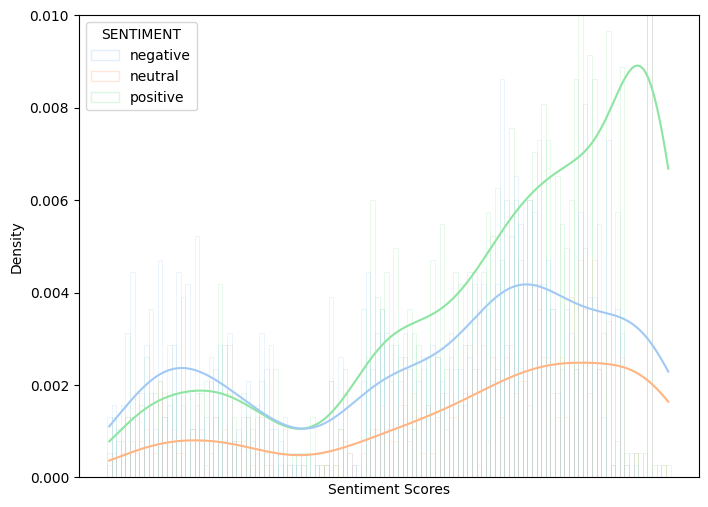

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='Date Flown', hue='SENTIMENT', bins=40, kde=True, fill=False, stat='density', alpha=0.3, palette='pastel')
plt.xlabel("Sentiment Scores")
plt.ylabel("Density")
plt.ylim(0, 0.01)
plt.xticks([])
plt.show()